# 统计第一次停留点和只访问过一次停留点的占比

按照 Understanding predictability and exploration in human mobility 文中的定义来计算。

## 1 新地点（Exploration）

对 **每个用户**，按时间排序的地点序列：

- 若当前位置 **在该用户历史中从未出现过**
- 则该一次访问记为 **exploration**

例子（论文原文）：
```text
A B A C B C  
→ 1 1 0 1 0 0
```

统计量：

$$
\text{Exploration Ratio}
= \frac{\#\text{exploration visits}}{\#\text{total visits}}
$$

---

## 2. 只访问过一次的地点

对 **每个用户**：

- 统计其所有访问过的唯一地点
- 其中 **访问次数 = 1 的地点数**
- 占 **唯一地点总数** 的比例

$$
\text{Once-Visited Location Ratio}
= \frac{\#\text{locations visited once}}{\#\text{unique locations}}
$$


In [9]:
import pandas as pd
import matplotlib.pyplot as plt

def statisticplot(sourcepath:str="./Data/Output/all_users_context_combined.csv", 
                  savepath :str='./Data/Output/GeoLife_ExplorationRatio_OnceVisitedLocationRatio.csv')->None:
    # =========================
    # 1) Load & column mapping
    # =========================
    CSV_PATH = sourcepath
    df = pd.read_csv(CSV_PATH)

    # Your file columns:
    # ['Unnamed: 0','userID','stime','etime','lon','lat','duration','grid','context_fuzzy','context_precise']
    # Map them to unified names
    df = df.rename(columns={
        "userID": "userID",
        "stime": "stime",      # start time of the stay/record
        "grid": "grid"      # treat grid as place/location id
    })

    # Parse time and sort per user (CRITICAL for exploration definition)
    df["stime"] = pd.to_datetime(df["stime"])
    df = df.sort_values(["userID", "stime"])


    # =========================
    # 2) Per-user statistics
    # =========================
    def compute_user_stats(user_df: pd.DataFrame) -> pd.Series:
        """
        Per user:
        - exploration_ratio: fraction of visits to a 'new' location (first time seen in the sequence)
        - once_visited_location_ratio: fraction of unique locations visited exactly once
        """
        locations = user_df["grid"].tolist()

        # --- Exploration (new place) ratio ---
        seen = set()
        exploration_count = 0
        for loc in locations:
            if loc not in seen:
                exploration_count += 1
                seen.add(loc)
        exploration_ratio = exploration_count / len(locations) if locations else float("nan")

        # --- Visited-only-once ratio over unique locations ---
        loc_counts = pd.Series(locations).value_counts()
        once_visited_location_ratio = ((loc_counts == 1).sum() / len(loc_counts)) if len(loc_counts) else float("nan")

        return pd.Series({
            "exploration_ratio": exploration_ratio,
            "once_visited_location_ratio": once_visited_location_ratio,
            "num_visits": len(locations),
            "num_unique_locations": len(loc_counts)
        })


    user_stats = (
        df.groupby("userID", group_keys=False)
        .apply(compute_user_stats)
        .reset_index()
    )

    user_stats.to_csv(savepath)


    # =========================
    # 3) Plot (Figure 6A & 6B style)
    # =========================
    BINS = 30

    # Figure 6(A): fraction of locations visited only once (per user)
    plt.figure()
    plt.hist(user_stats["once_visited_location_ratio"].dropna(), bins=BINS)
    plt.xlabel("Fraction of locations visited once")
    plt.ylabel("Number of users")
    plt.title("Fraction of places visited only once per user")
    plt.tight_layout()
    plt.show()

    # Figure 6(B): probability of exploration (per user)
    plt.figure()
    plt.hist(user_stats["exploration_ratio"].dropna(), bins=BINS)
    plt.xlabel("Exploration probability")
    plt.ylabel("Number of users")
    plt.title("Probability of exploration per user")
    plt.tight_layout()
    plt.show()


    # =========================
    # 4) Optional sanity check
    # =========================
    print("Mean once_visited_location_ratio:", user_stats["once_visited_location_ratio"].mean())
    print("Mean exploration_ratio:", user_stats["exploration_ratio"].mean())

C:\Users\Administrator\AppData\Local\Temp\ipykernel_11764\3428831942.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_user_stats)


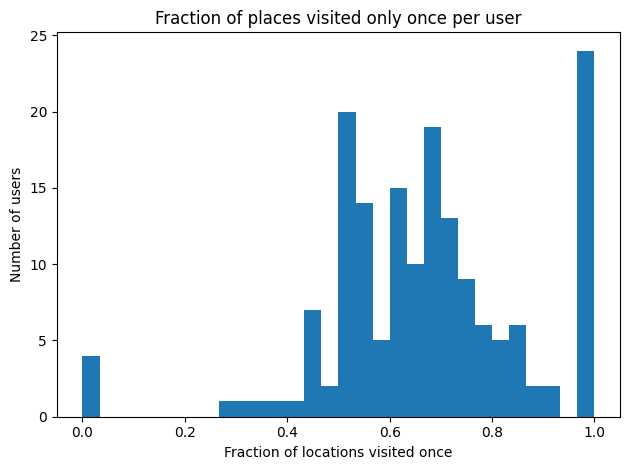

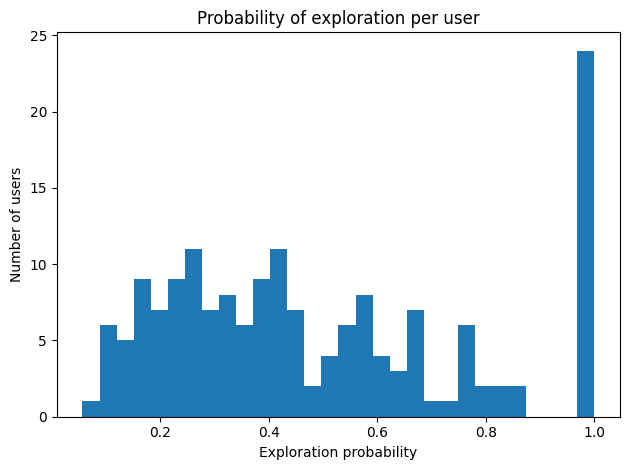

Mean once_visited_location_ratio: 0.6696368295305464
Mean exploration_ratio: 0.487610309921031


In [12]:
statisticplot(sourcepath='./Data/Output/all_users_context_combined_gapLE0_merged.csv')

C:\Users\Administrator\AppData\Local\Temp\ipykernel_11764\3428831942.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_user_stats)


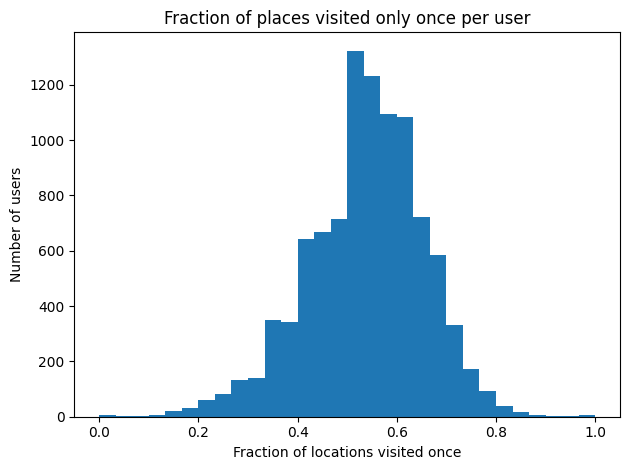

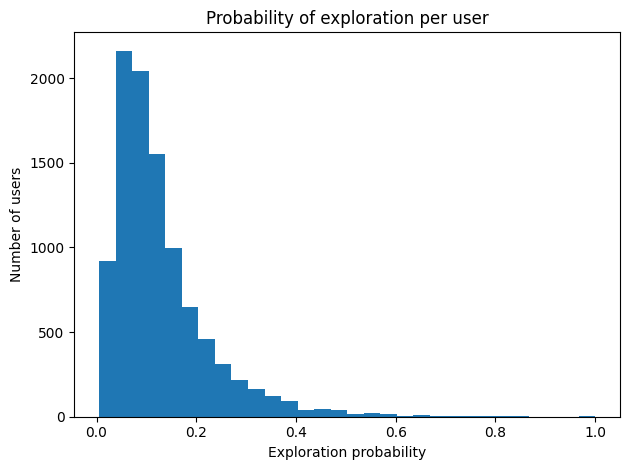

Mean once_visited_location_ratio: 0.5353794403510017
Mean exploration_ratio: 0.12847563521349303


In [13]:
statisticplot(sourcepath="./Data/MoreUser/all_merged30min.csv", 
              savepath='./Data/MoreUser/MoreUser_ExplorationRatio_OnceVisitedLocationRatio.csv')